In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataloader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.cuda.amp import GradScaler, autocast
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import seaborn as sns
# Import confusion_matrix and classification_report
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# Set location of data sources
train_loc = '/content/drive/MyDrive/Colab Notebooks/Capstone Project/train' # Sets the location of the training data
val_loc = '/content/drive/MyDrive/Colab Notebooks/Capstone Project/val' # Sets the location of the validation data
test_loc = '/content/drive/MyDrive/Colab Notebooks/Capstone Project/test' # Sets the location of the testing data

In [ ]:
# The model was trained using google colab. If you have access to colab GPU's it is suggested you use the below code to help speed up training. 
# If not but have an Nvidea GPU. CUDA can be installed and used to speed up the run. 
# Otherwise this code is not nessecary. 
def setup_colab():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.is_available(): 
        torch.backends.cudnn.benchmark = True # Enable cuDNN auto-tuner to find fastest convolution algorithms
        torch.backends.cuda.matmul.allow_tf32 = True # Enable TensorFloat-32 for potential speedup
        torch.backends.cudnn.allow_tf32 = True
    return device

In [ ]:
# Define transforms for AlexNet
# The values can be changed/tuned to try improve results
# Data augmentation and normalization for training
# These transformations help prevent overfitting by creating variations in the images
# The values used for normalization are the standard ImageNet values which work well with ResNet
transform_train = transforms.Compose([
   transforms.Resize((256, 256)),  # Resize all images to 256x256
   transforms.RandomCrop(224),  # Randomly crop to 224x224 for training variety 
   transforms.RandomHorizontalFlip(),  # Randomly flip image horizontally
   transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Randomly adjust brightness and contrast
   transforms.ToTensor(),  # Convert image to PyTorch tensor
   transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # Normalize using ImageNet values
])

# Simpler transformations for evaluation/testing
transform_eval = transforms.Compose([
   transforms.Resize((256, 256)), 
   transforms.CenterCrop(224),  # Center crop to 224x224 for consistent evaluation
   transforms.ToTensor(), 
   transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) 
])

In [ ]:
# Implementation of AlexNet architecture
class AlexNet(nn.Module):
   def __init__(self, num_classes):
       super(AlexNet, self).__init__()
       # Feature extraction layers
       self.features = nn.Sequential(
           nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),  # First conv layer with large kernel
           nn.ReLU(inplace=True),
           nn.MaxPool2d(kernel_size=3, stride=2),  # Reduce spatial dimensions
           nn.Conv2d(64, 192, kernel_size=5, padding=2),  # Second conv layer
           nn.ReLU(inplace=True),
           nn.MaxPool2d(kernel_size=3, stride=2),
           nn.Conv2d(192, 384, kernel_size=3, padding=1),  # Third conv layer
           nn.ReLU(inplace=True),
           nn.Conv2d(384, 256, kernel_size=3, padding=1),  # Fourth conv layer
           nn.ReLU(inplace=True),
           nn.Conv2d(256, 256, kernel_size=3, padding=1),  # Fifth conv layer
           nn.ReLU(inplace=True),
           nn.MaxPool2d(kernel_size=3, stride=2),
       )
       # Classification layers with dropout for regularization
       self.classifier = nn.Sequential(
           nn.Dropout(),  # First dropout layer
           nn.Linear(256 * 6 * 6, 4096),  # First fully connected layer
           nn.ReLU(inplace=True),
           nn.Dropout(),  # Second dropout layer
           nn.Linear(4096, 4096),  # Second fully connected layer
           nn.ReLU(inplace=True),
           nn.Linear(4096, num_classes),  # Output layer
       )

   def forward(self, x):
       x = self.features(x)  # Pass through feature extraction layers
       x = torch.flatten(x, 1)  # Flatten for fully connected layers
       x = self.classifier(x)  # Pass through classification layers
       return x

In [ ]:
# Training function for AlexNet model
# Similar to ResNet training but with AlexNet specific hyperparameters
# Uses mixed precision training and learning rate scheduling
# IMPORTANT : Please read this section carefully. If you aren't using CUDA modifications to the code need to be made.
def train_alexnet():
   device = setup_colab()  # Set up GPU if available
   scaler = GradScaler()  # For mixed precision training

   # Load and prepare datasets with the defined transformations
   train_dataset = ImageFolder(train_loc, transform=transform_train)
   val_dataset = ImageFolder(val_loc, transform=transform_eval)
   test_dataset = ImageFolder(test_loc, transform=transform_eval)

   # Create data loaders with appropriate batch sizes and workers
   train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,
                           num_workers=2, pin_memory=True)
   val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False,
                         num_workers=2, pin_memory=True)
   test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False,
                          num_workers=2, pin_memory=True)

   # Initialize model, loss function, optimizer and learning rate scheduler
   model = AlexNet(num_classes=len(train_dataset.classes)).to(device)
   criterion = nn.CrossEntropyLoss()
   optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)  # Modified learning rate and weight decay
   scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  # Step scheduler instead of cosine

   # Training parameters and tracking variables
   num_epochs = 50
   best_val_acc = 0.0
   history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'epoch_times': []}

   # Training loop
   for epoch in range(num_epochs):
       epoch_start = time.time()
       model.train()
       running_loss = 0.0

       # Train one epoch
       for i, (images, labels) in enumerate(train_loader):
           images, labels = images.to(device), labels.to(device)

           optimizer.zero_grad()  # Clear gradients

           # Forward pass with mixed precision
           with autocast():
               outputs = model(images)
               loss = criterion(outputs, labels)

           # Backward pass with gradient scaling
           scaler.scale(loss).backward()
           scaler.step(optimizer)
           scaler.update()

           running_loss += loss.item()

           # Print training progress
           if (i + 1) % 10 == 0:
               print(f'Epoch [{epoch+1}/{num_epochs}], '
                     f'Step [{i+1}/{len(train_loader)}], '
                     f'Loss: {loss.item():.4f}')

           # Clear GPU cache periodically
           # REMOVE IF NOT IN USE
           if i % 50 == 0:
               torch.cuda.empty_cache()

       # Validation phase
       model.eval()
       val_loss = 0.0
       correct = 0
       total = 0

       # Compute validation metrics
       with torch.no_grad():
           for images, labels in val_loader:
               images, labels = images.to(device), labels.to(device)
               with autocast():
                   outputs = model(images)
                   loss = criterion(outputs, labels)

               val_loss += loss.item()
               _, predicted = torch.max(outputs.data, 1)
               total += labels.size(0)
               correct += (predicted == labels).sum().item()

       # Calculate epoch metrics
       avg_train_loss = running_loss / len(train_loader)
       avg_val_loss = val_loss / len(val_loader)
       val_accuracy = 100 * correct / total
       epoch_time = time.time() - epoch_start

       # Update history
       history['train_loss'].append(avg_train_loss)
       history['val_loss'].append(avg_val_loss)
       history['val_acc'].append(val_accuracy)
       history['epoch_times'].append(epoch_time)

       # Print epoch results
       print(f'Epoch [{epoch+1}/{num_epochs}]:')
       print(f'Training Loss: {avg_train_loss:.4f}')
       print(f'Validation Loss: {avg_val_loss:.4f}')
       print(f'Validation Accuracy: {val_accuracy:.2f}%')
       print(f'Epoch Time: {epoch_time:.2f} seconds')

       # Save best model
       if val_accuracy > best_val_acc:
           best_val_acc = val_accuracy
           torch.save({
               'epoch': epoch,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'best_val_acc': best_val_acc,
           }, 'best_alexnet.pth')

       scheduler.step()  # Update learning rate

   return model, history, best_val_acc

In [23]:
def plot_confusion_matrix(all_labels, all_predictions, class_names, accuracy):
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Create figure
    plt.figure(figsize=(20, 8))

    # Plot confusion matrix
    plt.subplot(121)
    sns.heatmap(cm,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)

    plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}%')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Rotate labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    # Plot class accuracies
    plt.subplot(122)
    class_accuracy = (cm.diagonal() / cm.sum(axis=1)) * 100

    # Create bar plot
    bars = plt.bar(range(len(class_names)), class_accuracy)

    # Add percentage labels on top of bars
    for idx, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom')

    plt.title('Per-Class Accuracy')
    plt.xlabel('Classes')
    plt.ylabel('Accuracy (%)')
    plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
    plt.ylim(0, 100)

    plt.tight_layout()
    return plt.gcf()

In [ ]:
# Training function for AlexNet model
# Similar to ResNet training but with AlexNet specific hyperparameters
# Uses mixed precision training and learning rate scheduling
def train_alexnet():
   device = setup_colab()  # Set up GPU if available
   scaler = GradScaler()  # For mixed precision training

   # Load and prepare datasets with the defined transformations
   train_dataset = ImageFolder(train_loc, transform=transform_train)
   val_dataset = ImageFolder(val_loc, transform=transform_eval)
   test_dataset = ImageFolder(test_loc, transform=transform_eval)

   # Create data loaders with appropriate batch sizes and workers
   train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,
                           num_workers=2, pin_memory=True)
   val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False,
                         num_workers=2, pin_memory=True)
   test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False,
                          num_workers=2, pin_memory=True)

   # Initialize model, loss function, optimizer and learning rate scheduler
   model = AlexNet(num_classes=len(train_dataset.classes)).to(device)
   criterion = nn.CrossEntropyLoss()
   optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)  # Modified learning rate and weight decay
   scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  # Step scheduler instead of cosine

   # Training parameters and tracking variables
   num_epochs = 50
   best_val_acc = 0.0
   history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'epoch_times': []}

   # Training loop
   for epoch in range(num_epochs):
       epoch_start = time.time()
       model.train()
       running_loss = 0.0

       # Train one epoch
       for i, (images, labels) in enumerate(train_loader):
           images, labels = images.to(device), labels.to(device)

           optimizer.zero_grad()  # Clear gradients

           # Forward pass with mixed precision
           with autocast():
               outputs = model(images)
               loss = criterion(outputs, labels)

           # Backward pass with gradient scaling
           scaler.scale(loss).backward()
           scaler.step(optimizer)
           scaler.update()

           running_loss += loss.item()

           # Print training progress
           if (i + 1) % 10 == 0:
               print(f'Epoch [{epoch+1}/{num_epochs}], '
                     f'Step [{i+1}/{len(train_loader)}], '
                     f'Loss: {loss.item():.4f}')

           # Clear GPU cache periodically
           if i % 50 == 0:
               torch.cuda.empty_cache()

       # Validation phase
       model.eval()
       val_loss = 0.0
       correct = 0
       total = 0

       # Compute validation metrics
       with torch.no_grad():
           for images, labels in val_loader:
               images, labels = images.to(device), labels.to(device)
               with autocast():
                   outputs = model(images)
                   loss = criterion(outputs, labels)

               val_loss += loss.item()
               _, predicted = torch.max(outputs.data, 1)
               total += labels.size(0)
               correct += (predicted == labels).sum().item()

       # Calculate epoch metrics
       avg_train_loss = running_loss / len(train_loader)
       avg_val_loss = val_loss / len(val_loader)
       val_accuracy = 100 * correct / total
       epoch_time = time.time() - epoch_start

       # Update history
       history['train_loss'].append(avg_train_loss)
       history['val_loss'].append(avg_val_loss)
       history['val_acc'].append(val_accuracy)
       history['epoch_times'].append(epoch_time)

       # Print epoch results
       print(f'Epoch [{epoch+1}/{num_epochs}]:')
       print(f'Training Loss: {avg_train_loss:.4f}')
       print(f'Validation Loss: {avg_val_loss:.4f}')
       print(f'Validation Accuracy: {val_accuracy:.2f}%')
       print(f'Epoch Time: {epoch_time:.2f} seconds')

       # Save best model
       if val_accuracy > best_val_acc:
           best_val_acc = val_accuracy
           torch.save({
               'epoch': epoch,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'best_val_acc': best_val_acc,
           }, 'best_alexnet.pth')

       scheduler.step()  # Update learning rate

   return model, history, best_val_acc

<ipython-input-22-b94d6df6acad>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-22-b94d6df6acad>:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/50], Step [10/329], Loss: 3.4027
Epoch [1/50], Step [20/329], Loss: 3.4025
Epoch [1/50], Step [30/329], Loss: 3.4016
Epoch [1/50], Step [40/329], Loss: 3.3991
Epoch [1/50], Step [50/329], Loss: 3.4019
Epoch [1/50], Step [60/329], Loss: 3.3999
Epoch [1/50], Step [70/329], Loss: 3.4019
Epoch [1/50], Step [80/329], Loss: 3.3969
Epoch [1/50], Step [90/329], Loss: 3.3994
Epoch [1/50], Step [100/329], Loss: 3.4000
Epoch [1/50], Step [110/329], Loss: 3.3948
Epoch [1/50], Step [120/329], Loss: 3.3993
Epoch [1/50], Step [130/329], Loss: 3.3943
Epoch [1/50], Step [140/329], Loss: 3.4049
Epoch [1/50], Step [150/329], Loss: 3.4026
Epoch [1/50], Step [160/329], Loss: 3.3902
Epoch [1/50], Step [170/329], Loss: 3.3863
Epoch [1/50], Step [180/329], Loss: 3.3494
Epoch [1/50], Step [190/329], Loss: 3.3204
Epoch [1/50], Step [200/329], Loss: 3.2321
Epoch [1/50], Step [210/329], Loss: 3.1425
Epoch [1/50], Step [220/329], Loss: 3.1513
Epoch [1/50], Step [230/329], Loss: 3.1202
Epoch [1/50], Step [

<ipython-input-22-b94d6df6acad>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/50]:
Training Loss: 3.2470
Validation Loss: 2.9376
Validation Accuracy: 11.84%
Epoch Time: 7889.61 seconds
Epoch [2/50], Step [10/329], Loss: 2.8575
Epoch [2/50], Step [20/329], Loss: 2.7658
Epoch [2/50], Step [30/329], Loss: 2.9711
Epoch [2/50], Step [40/329], Loss: 2.9494
Epoch [2/50], Step [50/329], Loss: 2.7914
Epoch [2/50], Step [60/329], Loss: 2.7064
Epoch [2/50], Step [70/329], Loss: 3.1081
Epoch [2/50], Step [80/329], Loss: 2.5739
Epoch [2/50], Step [90/329], Loss: 2.7910
Epoch [2/50], Step [100/329], Loss: 2.7958
Epoch [2/50], Step [110/329], Loss: 2.7450
Epoch [2/50], Step [120/329], Loss: 2.9959
Epoch [2/50], Step [130/329], Loss: 3.0168
Epoch [2/50], Step [140/329], Loss: 2.6332
Epoch [2/50], Step [150/329], Loss: 2.7009
Epoch [2/50], Step [160/329], Loss: 2.9408
Epoch [2/50], Step [170/329], Loss: 2.8574
Epoch [2/50], Step [180/329], Loss: 2.6757
Epoch [2/50], Step [190/329], Loss: 3.0785
Epoch [2/50], Step [200/329], Loss: 2.6849
Epoch [2/50], Step [210/329], Los

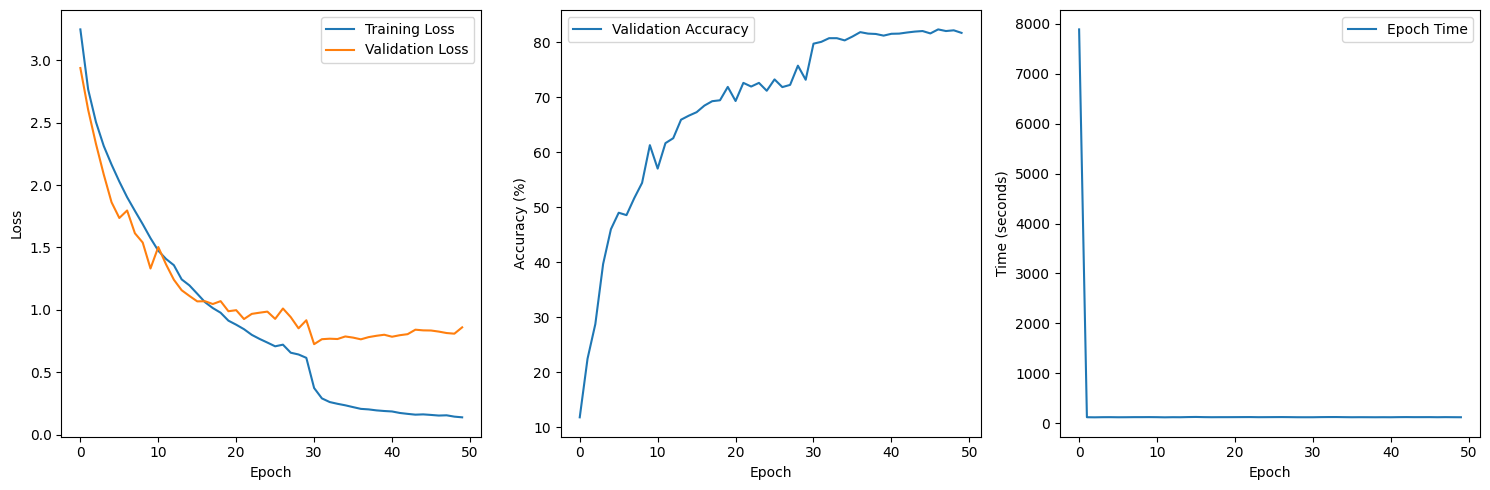

Best Validation Accuracy: 82.30%


In [ ]:
# Main execution block
# Trains the AlexNet model and visualizes the training metrics
# Creates three plots: loss curves, accuracy progression, and training time per epoch
if __name__ == '__main__':
    model, history, best_acc = train_alexnet()

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(history['epoch_times'], label='Epoch Time')
    plt.xlabel('Epoch')
    plt.ylabel('Time (seconds)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f'Best Validation Accuracy: {best_acc:.2f}%')


Testing the best model...


<ipython-input-24-8540c47174d8>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
<ipython-input-24-8540c47174d8>:27: FutureWarning: `torc


Test Accuracy: 75.13%

Classification Report:
               precision    recall  f1-score   support

     aloevera       0.90      0.80      0.84       200
       banana       0.84      0.52      0.64       200
      bilimbi       0.69      0.81      0.75       200
   cantaloupe       0.32      0.06      0.10       200
      cassava       0.62      0.78      0.69       200
      coconut       0.61      0.43      0.50       200
         corn       0.68      0.86      0.76       200
     cucumber       0.76      0.85      0.80       200
      curcuma       0.75      0.81      0.78       200
     eggplant       0.74      0.90      0.81       200
     galangal       0.71      0.90      0.79       200
       ginger       0.71      0.69      0.70       200
        guava       0.76      0.74      0.75       200
         kale       0.89      0.64      0.74       200
    longbeans       0.82      0.86      0.84       200
        mango       0.75      0.62      0.68       200
        melon    

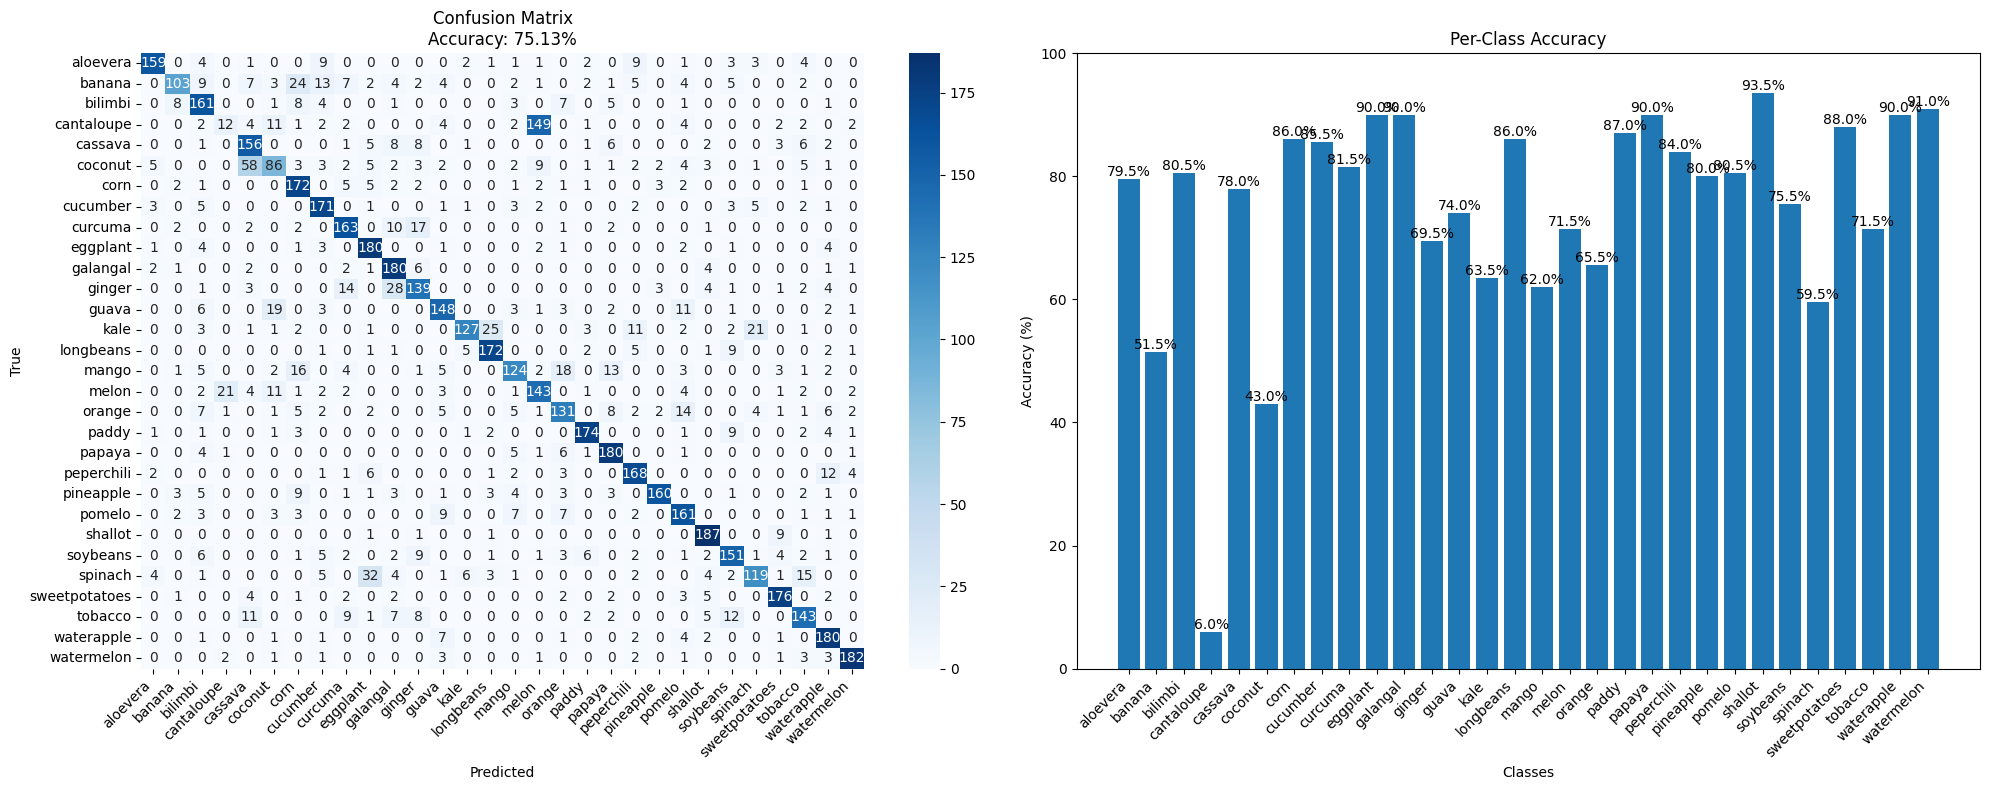

In [ ]:
# Test best model on test dataset
# Load the saved model from Google Drive and evaluate its performance
# IMPORTANT: Please update model path
print("\nTesting the best model...")
model_path = '/content/drive/MyDrive/Colab Notebooks/Capstone Project/best_alexnet.pth'
accuracy, confusion_mat, report = test_model(model_path, test_loc, AlexNet)